In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering,KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan
from sklearn.mixture import GaussianMixture
from scipy.optimize import fmin
import networkx as nx
import seaborn as sns

### **IMPORTATION DES DONNEES**

*diamètres des adipocytes sous cutané et viscéral*

In [2]:
scdf = pd.read_csv("sc.csv", delimiter=',') # diamètre des adipocytes sous cutanés
omdf = pd.read_csv("om.csv", delimiter=',') # diamètre des adipocytes viscéral

*fonctions*

In [3]:
# fonction de lissage
def smooth(h,w):
    a = np.zeros(len(h))
    nx = len(h)
    for i in range(nx):
        if i<w :
            a[i] = np.sum(h[0:i+w])/(w+i)

        elif i+w > nx:
            a[i] = np.sum(h[i-w:])/(w + nx - i)
        else:
            a[i] = np.sum(h[i-w:i+w])/(2*w)
    return a

# fonction transformation diamètres en quantité de lipides
def lipids(taille):
    r = taille/2
    Vl = 1.091 * 1e6
    return ((4/3) * np.pi * (r** 3 - 10 **3)) / Vl

*fréquences de l'histogramme pour sous cutané et viscéral*

In [4]:
binning = np.linspace(20,200,50)
# choix de lissage : w = 2

np_frequences_sc=[]
np_frequences_om=[]
for patient in range(1,225) :    
    h1 = scdf[f"patient {patient}"].dropna()    
    h2 = omdf[f"patient {patient}"].dropna()        
    data1,b=np.histogram(h1,bins=binning,density=True)
    data2,b=np.histogram(h2,bins=binning,density=True)
    np_frequences_sc.append(smooth(data1,2))
    np_frequences_om.append(smooth(data2,2))         

frequences_sc = pd.DataFrame(np.array(np_frequences_sc).T)
frequences_om = pd.DataFrame(np.array(np_frequences_om).T)
frequences_sc.columns =[f"patient {i}" for i in range(1,225)]
frequences_om.columns =[f"patient {i}" for i in range(1,225)]


### **PLOT DES HISTOGRAMMES** ###
enlever commentaire sur *plt.show()* pour plot

In [5]:
# plot des histogrammes sous cutanés
for i in range(1,225):
    plt.figure()

    h=scdf[f"patient {i}"].dropna()
    data,b=np.histogram(h,bins=binning,density=True)
 
    X = (b[1:] + b[:-1])/2
    plt.hist(h, bins=binning, density=True,alpha=0.5, label='données brutes') 
    plt.plot(X,frequences_sc[f"patient {i}"],label="courbe de fréquences lissées")
    plt.legend()
    plt.title(f"[TISSU ADIPEUX SOUS CUTANÉ]\nhistogramme du patient {i}")
    plt.xlabel("taille des adipocytes (µm)")
    plt.ylabel("frequence")
    # plt.show()
    plt.close()

# plot des histogrammes viscéral
for i in range(1,225):
    plt.figure()

    h=omdf[f"patient {i}"].dropna()
    data,b=np.histogram(h,bins=binning,density=True)
 
    X = (b[1:] + b[:-1])/2
    plt.hist(h, bins=binning, density=True,alpha=0.5, label='données brutes') 
    plt.plot(X,frequences_om[f"patient {i}"],label="courbe de fréquences lissées")
    plt.legend()
    plt.title(f"[TISSU ADIPEUX VISCERAL]\nhistogramme du patient {i}")
    plt.xlabel("taille des adipocytes (µm)")
    plt.ylabel("frequence")
    # plt.show()
    plt.close()

### **CLUSTERING SPECTRAL** ###

In [6]:
frequences_sscut = np.array(frequences_sc.T)         # conversion en matrice
frequences_visc = np.array(frequences_om.T) 

model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')       
labels_sc = model.fit_predict(frequences_sscut)
labels_om = model.fit_predict(frequences_visc)

labels du clustering

In [7]:
df_labels = pd.DataFrame(list(zip(labels_sc, labels_om)),columns=["n°cluster_TA_sc","n°cluster_TA_om"])
df_labels.index=[f"patient {i}" for i in range(1,len(labels_sc)+1)] 
df_labels

n°cluster_TA_sc  n°cluster_TA_om
patient 1                  0                0
patient 2                  0                1
patient 3                  0                1
patient 4                  2                1
patient 5                  2                1
...                      ...              ...
patient 220                1                0
patient 221                1                2
patient 222                1                1
patient 223                0                0
patient 224                0                1

[224 rows x 2 columns]

Séparation fréquences pour les 3 clusters du clustering spectral

In [8]:
# définition des labels sous cutané et viscéral
df_sc_0 = df_labels["n°cluster_TA_sc"][df_labels["n°cluster_TA_sc"]==0]
df_sc_1 = df_labels["n°cluster_TA_sc"][df_labels["n°cluster_TA_sc"]==1]
df_sc_2 = df_labels["n°cluster_TA_sc"][df_labels["n°cluster_TA_sc"]==2]

df_om_0=df_labels["n°cluster_TA_om"][df_labels["n°cluster_TA_om"]==0]
df_om_1=df_labels["n°cluster_TA_om"][df_labels["n°cluster_TA_om"]==1]
df_om_2=df_labels["n°cluster_TA_om"][df_labels["n°cluster_TA_om"]==2]

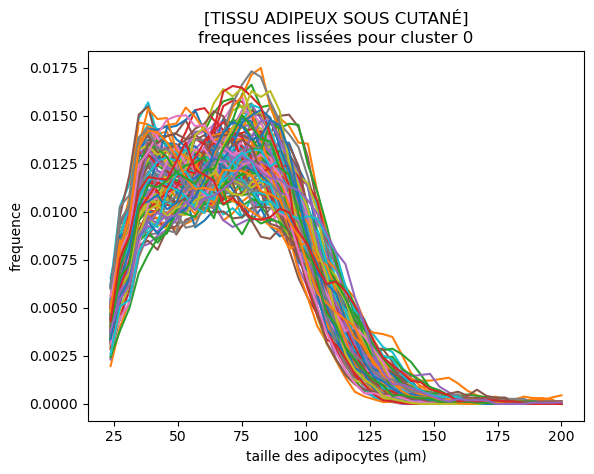

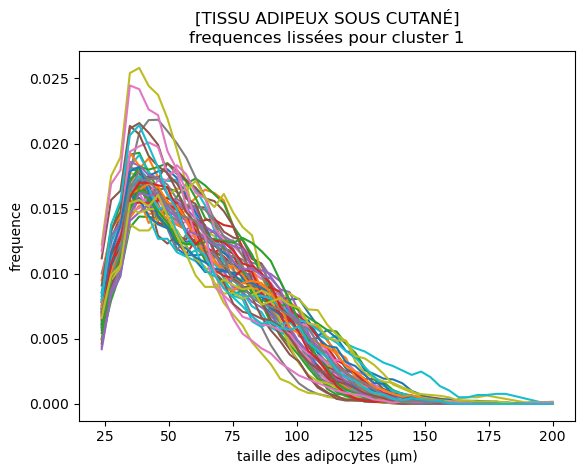

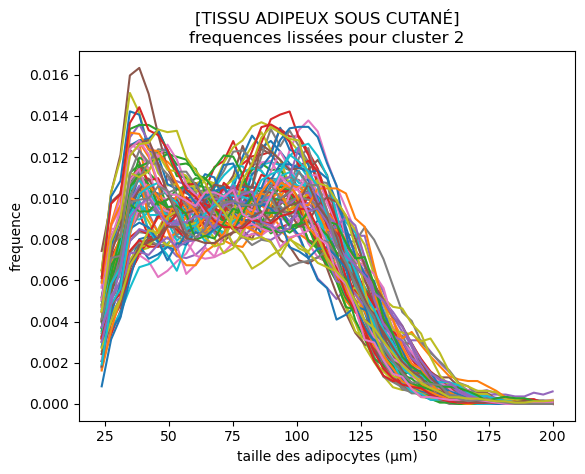

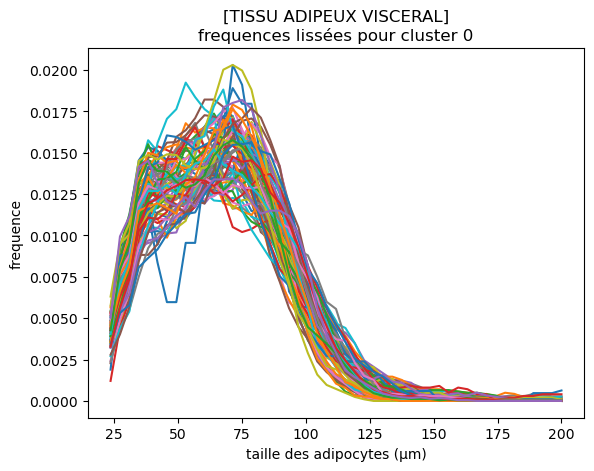

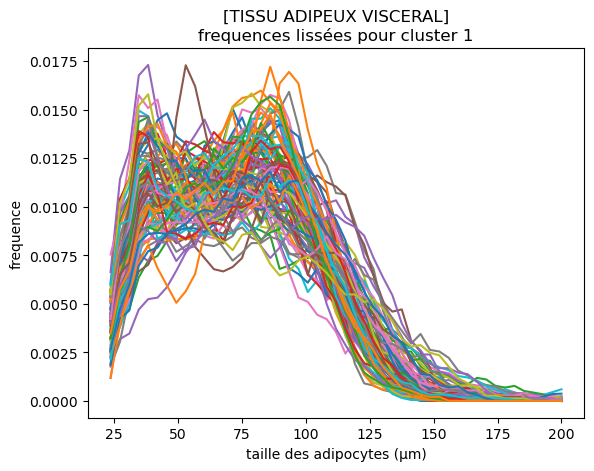

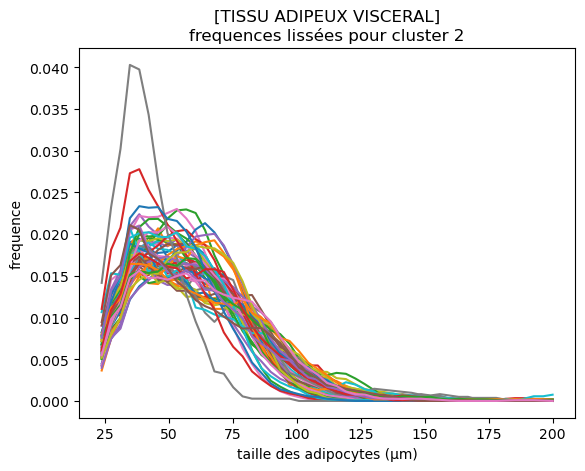

In [9]:
# SOUS CUTANE -- plot des histogrammes

plt.figure()
for index in df_sc_0.index.tolist():
    plt.plot(b[1:],frequences_sc[index])
# plt.axvline()
plt.title(f"[TISSU ADIPEUX SOUS CUTANÉ]\nfrequences lissées pour cluster 0")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  

plt.figure()
for index in df_sc_1.index.tolist():
    plt.plot(b[1:],frequences_sc[index],label="courbe de fréquences lissées")
# plt.axvline()
plt.title(f"[TISSU ADIPEUX SOUS CUTANÉ]\nfrequences lissées pour cluster 1")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  


plt.figure()
for index in df_sc_2.index.tolist():
    plt.plot(b[1:],frequences_sc[index],label="courbe de fréquences lissées")
# plt.axvline()
plt.title(f"[TISSU ADIPEUX SOUS CUTANÉ]\nfrequences lissées pour cluster 2")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  

# VISCERAL -- plot des histogrammes

plt.figure()
for index in df_om_0.index.tolist():
    plt.plot(b[1:],frequences_om[index],label="courbe de fréquences lissées")
# plt.axvline()
plt.title(f"[TISSU ADIPEUX VISCERAL]\nfrequences lissées pour cluster 0")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  


plt.figure()
for index in df_om_1.index.tolist():
    plt.plot(b[1:],frequences_om[index],label="courbe de fréquences lissées")
# plt.axvline()
plt.title(f"[TISSU ADIPEUX VISCERAL]\nfrequences lissées pour cluster 1")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  


plt.figure()
for index in df_om_2.index.tolist():
    plt.plot(b[1:],frequences_om[index],label="courbe de fréquences lissées")
# plt.axvline()
plt.title(f"[TISSU ADIPEUX VISCERAL]\nfrequences lissées pour cluster 2")
plt.xlabel("taille des adipocytes (µm)")
plt.ylabel("frequence")
plt.show()  

#### REDUCTION DIMENSIONS SUR CLUSTERING SPECTRAL ####

SOUS CUTANE

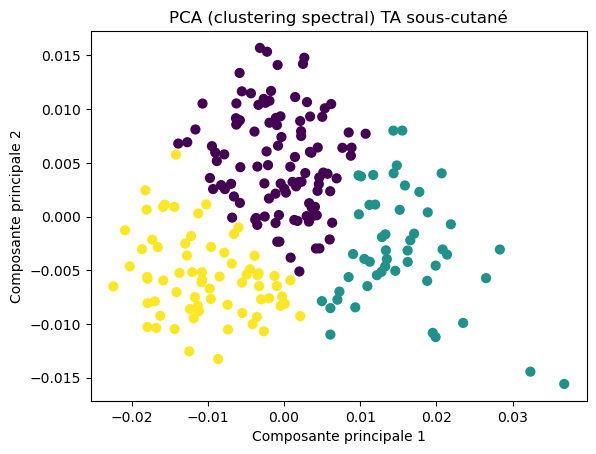

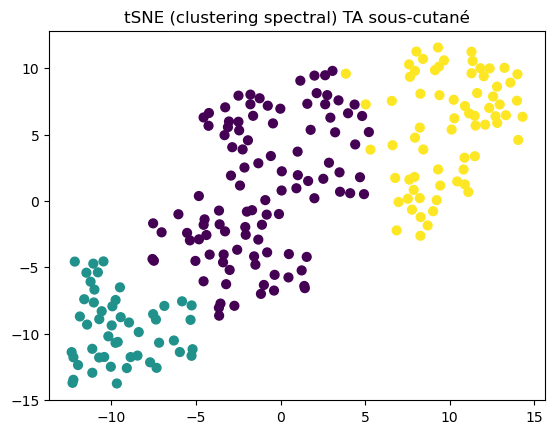

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


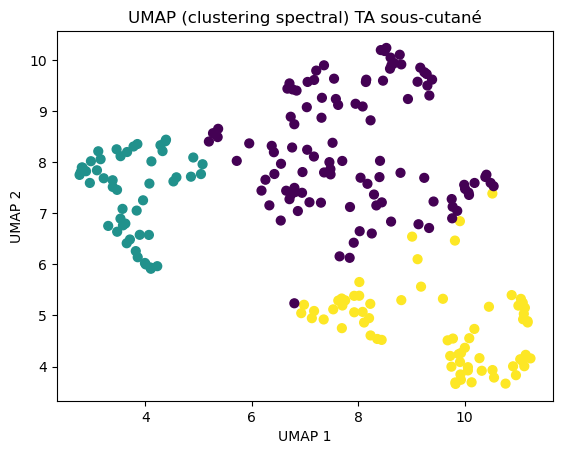

In [10]:
# PCA sous cutané sur les fréquences
pca = PCA(n_components=2)
frequences_pca_sc = pca.fit_transform(frequences_sscut)

plt.figure()
plt.scatter(frequences_pca_sc[:, 0], frequences_pca_sc[:, 1], c=labels_sc, cmap='viridis', s=40)   
plt.title(f"PCA (clustering spectral) TA sous-cutané")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

#%% tSNE  sous cutané sur les fréquences
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
frequences_tsne_sc = tsne.fit_transform(frequences_sscut)

plt.figure()
plt.scatter(frequences_tsne_sc[:, 0], frequences_tsne_sc[:, 1], c=labels_sc, cmap='viridis', s=40)
plt.title(f"tSNE (clustering spectral) TA sous-cutané")
plt.show()

#%% UMAP sous cutané sur les fréquences
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umap_sc = reducer.fit_transform(frequences_sscut)

plt.figure()
plt.scatter(frequences_umap_sc[:, 0], frequences_umap_sc[:, 1], c=labels_sc ,cmap='viridis', s=40)
plt.title(f"UMAP (clustering spectral) TA sous-cutané")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



VISCERAL

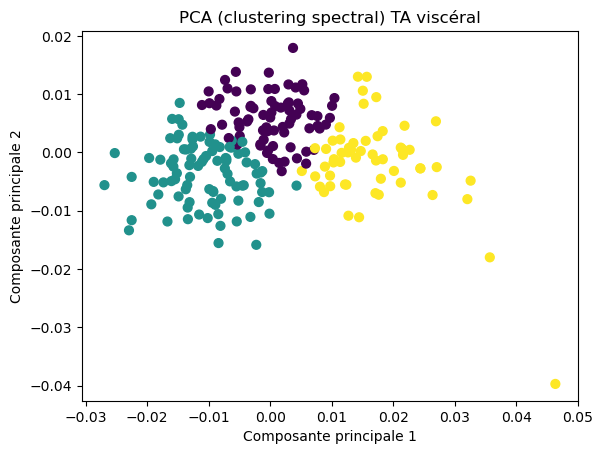

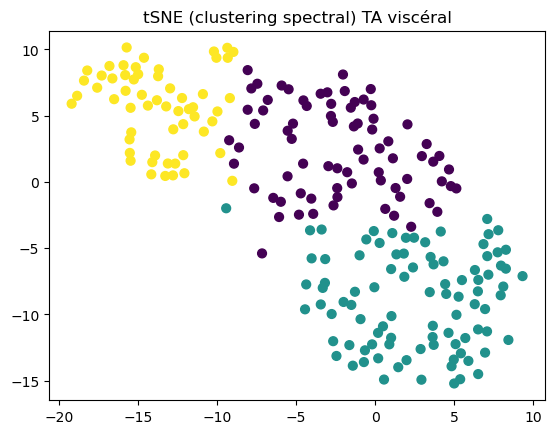

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


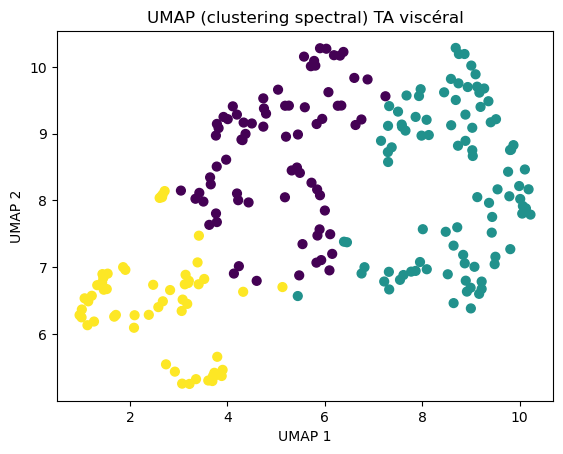

In [11]:
# PCA viscéral sur les fréquences
pca = PCA(n_components=2)
frequences_pca_om = pca.fit_transform(frequences_visc)

plt.figure()
plt.scatter(frequences_pca_om[:, 0], frequences_pca_om[:, 1], c=labels_om, cmap='viridis', s=40)   
plt.title(f"PCA (clustering spectral) TA viscéral")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

#%% tSNE  viscéral sur les fréquences
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
frequences_tsne_om = tsne.fit_transform(frequences_visc)

plt.figure()
plt.scatter(frequences_tsne_om[:, 0], frequences_tsne_om[:, 1], c=labels_om, cmap='viridis', s=40)
plt.title(f"tSNE (clustering spectral) TA viscéral")
plt.show()

#%% UMAP viscéral sur les fréquences
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umap_om = reducer.fit_transform(frequences_visc)

plt.figure()
plt.scatter(frequences_umap_om[:, 0], frequences_umap_om[:, 1], c=labels_om ,cmap='viridis', s=40)
plt.title(f"UMAP (clustering spectral) TA viscéral")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



### AUTRES CLUSTERINGS (*DBSCAN, HDBSCAN, kmeans, gaussian mixture*) ###

In [12]:
#DBSCAN 
clusterer_db = DBSCAN(eps=0.006, min_samples=4)  

labels_db_sc = clusterer_db.fit_predict(frequences_sscut)
labels_db_om = clusterer_db.fit_predict(frequences_visc)

#HDBSCAN
clusterer_hdb = hdbscan.HDBSCAN(min_cluster_size=5)

labels_hdb_sc = clusterer_hdb.fit_predict(frequences_sscut)
labels_hdb_om = clusterer_hdb.fit_predict(frequences_visc)

#kmeans
kmeans = KMeans(n_clusters=3, random_state=42)

labels_km_sc = kmeans.fit_predict(frequences_sscut)
labels_km_om = kmeans.fit_predict(frequences_visc)

#gaussian mixture
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

gmm.fit(frequences_sscut)
labels_gm = gmm.predict(frequences_sscut)
gmm.fit(frequences_visc)
labels_gm = gmm.predict(frequences_visc)

#### **COLORMAP VARIABLES METABOLIQUES** ###

In [ ]:
variables_métabo = pd.read_csv("NICOLE_Project.csv", sep=";", index_col=1)
df_aa = pd.read_csv("acides aminés.csv", sep=";", index_col=1)

variables_m={
        "BMI" : variables_métabo["BMI"].where(variables_métabo["BMI"]<64,np.nan), 
        "TG" : variables_métabo["Trigly"].where(variables_métabo["Trigly"]<6,np.nan), 
        "leptin" : variables_métabo["Leptine"].where(variables_métabo["Leptine"]<130,np.nan), 
        "HbA1c" : variables_métabo["HbA1C"].where(variables_métabo["HbA1C"]<9,np.nan), 
        "HOMA1_IR" : variables_métabo["HOMA1_IR"].where(variables_métabo["HOMA1_IR"]<16,np.nan), 
        "HOMA2_IR" : variables_métabo["HOMA2_IR"].where(variables_métabo["HOMA2_IR"]<7,np.nan), 
        "HDL" : variables_métabo["HDL"].where(variables_métabo["HDL"]<2,np.nan), 
        "LDL" : variables_métabo["LDL"].where(variables_métabo["LDL"]<5,np.nan), 
        "CRP" : variables_métabo["CRP"].where(variables_métabo["CRP"]<40,np.nan), 
        "FATscore" : variables_métabo["FATscore_scAT"], 
        "fatmass" : variables_métabo["percent_fat_mass"], 
        "alanine sc" : df_aa["AA-Alanine WAT SCAT"],
        "acide aspartique sc" : df_aa["AA-Aspartic acid WAT SCAT"],
        "acide glutamique sc" : df_aa["AA-Glutamic acid WAT SCAT"],
        "pyroglutamate sc" : df_aa["Pyroglutamate (from GLTM?) WAT SCAT"],
        "glycine sc" : df_aa["AA-Glycine WAT SCAT"],
        "glutamine sc" : df_aa["AA-Glutamine3TBDMS WAT SCAT"],
        "histidine sc" : df_aa["AA-Histidine WAT SCAT"],
        "isoleucine sc" : df_aa["AA-ISO-Leucine WAT SCAT"],
        "leucine sc" : df_aa["AA-Leucine WAT SCAT"],
        "lysine sc" : df_aa["AA-Lysine WAT SCAT"],
        "méthionine sc" : df_aa["AA-Methionine WAT SCAT"],
        "phenylalanine sc" : df_aa["AA-Phenylalanine WAT SCAT"],
        "proline sc" : df_aa["AA-Proline WAT SCAT"],
        "serine sc" : df_aa["AA-Serine WAT SCAT"],
        "threonine sc" : df_aa["AA-Threonine WAT SCAT"],
        "tyrosine sc" : df_aa["AA-Tyrosine WAT SCAT"], 
        "valine sc" : df_aa["AA-Valine WAT SCAT"],
        "alanine plasma" : df_aa["AA-Alanine plasma"], 
        "alanine om" : df_aa["AA-Alanine WAT VISAT"], 
        "acide aspartique om" : df_aa["AA-Aspartic acid WAT VISAT"],
        "acide glutamique om" : df_aa["AA-Glutamic acid WAT VISAT"], 
        "pyroglutamate om" : df_aa["Pyroglutamate (from GLTM?) WAT VISAT"],
        "glycine om" : df_aa["AA-Glycine WAT VISAT"], 
        "glutamine om" : df_aa["AA-Glutamine3TBDMS WAT VISAT"], 
        "histidine om" : df_aa["AA-Histidine WAT VISAT"],      
        "isoleucine om": pd.to_numeric(df_aa["AA-ISO-Leucine WAT VISAT"], errors="coerce").where(lambda x: x < 50),
        "leucine om": pd.to_numeric(df_aa["AA-Leucine WAT VISAT"], errors="coerce").where(lambda x: x < 135),
        "lysine om": pd.to_numeric(df_aa["AA-Lysine WAT VISAT"], errors="coerce").where(lambda x: x < 190),
        "méthionine om": pd.to_numeric(df_aa["AA-Methionine WAT VISAT"], errors="coerce").where(lambda x: x < 37),
        "phenylalanine om": pd.to_numeric(df_aa["AA-Phenylalanine WAT VISAT"], errors="coerce").where(lambda x: x < 75),
        "proline om": pd.to_numeric(df_aa["AA-Proline WAT VISAT"], errors="coerce").where(lambda x: x < 120),
        "serine om": pd.to_numeric(df_aa["AA-Serine WAT VISAT"], errors="coerce").where(lambda x: x < 160),
        "threonine om" : df_aa["AA-Threonine WAT VISAT"], 
        "tyrosine om" : df_aa["AA-Tyrosine WAT VISAT"], 
        "valine om" : df_aa["AA-Valine WAT VISAT"],
        "acide aspartique plasma" : df_aa["AA-Aspartic acid plasma"],
        "acide glutamique plasma" : df_aa["AA-Glutamic acid plasma"],
        "pyroglutamate plasma" : df_aa["Pyroglutamate (from GLTM?) plasma"],
        "glycine plasma" : df_aa["AA-Glycine plasma"],
        "glutamine plasma" : df_aa["AA-Glutamine3TBDMS plasma"],
        "histidine plasma" : df_aa["AA-Histidine plasma"],
        "isoleucine plasma" : df_aa["AA-ISO-Leucine plasma"],
        "leucine plasma" : df_aa["AA-Leucine plasma"].where(df_aa["AA-Leucine plasma"]<370,np.nan), 
        "lysine plasma" : df_aa["AA-Lysine plasma"],
        "méthionine plasma" : df_aa["AA-Methionine plasma"],
        "phenylalanine plasma" : df_aa["AA-Phenylalanine plasma"],
        "proline plasma" : df_aa["AA-Proline plasma"],
        "serine plasma" : df_aa["AA-Serine plasma"], 
        "threonine plasma" : df_aa["AA-Threonine plasma"], 
        "tyrosine plasma" : df_aa["AA-Tyrosine plasma"], 
        "valine plasma" : df_aa["AA-Valine plasma"]
        }

#PCA
pca = PCA(n_components=2)
frequences_pca = pca.fit_transform(frequences_sc.T.values)

n_vars = len(variables_m)
cols = 11
rows = 6
plt.subplots(6,11,figsize=(30,13))
for i, (varname, series) in enumerate(variables_m.items(), 1):  # i commence à 1
    plt.subplot(rows, cols, i)

    labels = pd.to_numeric(series, errors="coerce").values
    mask = ~np.isnan(labels)

    plt.scatter(frequences_pca[:, 0], frequences_pca[:, 1], color='lightgrey', alpha=0.3, s=15)
    scatter = plt.scatter(frequences_pca[mask, 0], frequences_pca[mask, 1], c=labels[mask], cmap='viridis', s=25)
    
    plt.title(varname, fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(scatter)

plt.suptitle("PCA sc")
plt.tight_layout()
plt.show()

#UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umapsc = reducer.fit_transform(frequences_sc.T.values)

n_vars = len(variables_m)
cols = 11
rows = 6
plt.subplots(6,11,figsize=(30,13))
for i, (varname, series) in enumerate(variables_m.items(), 1):  # i commence à 1
    plt.subplot(rows, cols, i)

    labels = pd.to_numeric(series, errors="coerce").values
    mask = ~np.isnan(labels)
    plt.scatter(frequences_umapsc[:, 0], frequences_umapsc[:, 1], color='grey',alpha=0.4,s=20)
    scatter = plt.scatter(frequences_umapsc[mask, 0], frequences_umapsc[mask, 1], c=labels[mask], cmap='viridis', s=25)    
    plt.title(varname, fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(scatter)

plt.suptitle("UMAP sc")
plt.tight_layout()
plt.show()

### **QUANTITE DE LIPIDES PAR PATIENT** ###

In [15]:
qtte_lpd_sc=lipids(scdf) #quantités lipides par cellule/partient sous-cutané
qtte_lpd_om=lipids(omdf) #quantités lipides par cellule/partient viscéral

sc_ltot=[]
om_ltot=[]
## calcul des quantités de lipides normalisées sur le nombre total de cellules
for patient in range(1,len(scdf.columns)+1) : 
    tot_sc=qtte_lpd_sc[f"patient {patient}"].dropna().sum()/len(qtte_lpd_sc[f"patient {patient}"].dropna())
    sc_ltot.append(tot_sc)

for patient in range(1,len(omdf.columns)+1) : 
    tot_om=qtte_lpd_om[f"patient {patient}"].dropna().sum()/len(qtte_lpd_om[f"patient {patient}"].dropna())
    om_ltot.append(tot_om)

df_lipids_sc = pd.DataFrame(sc_ltot,columns=["qtt_lipides_TA_sc"])
df_lipids_sc.index=[f"patient {patient}" for patient in range (1,225)]
df_lipids_om = pd.DataFrame(om_ltot,columns=["qtt_lipides_TA_om"])
df_lipids_om.index=[f"patient {patient}" for patient in range (1,225)]

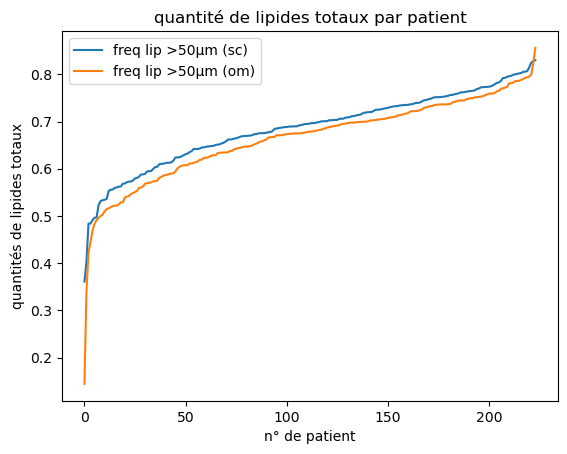

In [16]:
# SOUS CUTANE
seuil=50
proportion_big_sc=[]

for patient in range(1,len(scdf.columns)+1) :
    patient = scdf[f'patient {patient}'].dropna()
    proportion_big_sc.append(len(patient[patient>seuil])/len(patient))

for i in range(1,len(scdf.columns)+1) :
    proportion_sorted = np.sort(proportion_big_sc)
    
plt.figure()
plt.plot(proportion_sorted,label = f"freq lip >{seuil}µm (sc)")

# VISCERAL
proportion_big_om=[]

for i in range(1,len(omdf.columns)+1) :
    patient = omdf[f'patient {i}'].dropna()
    proportion_big_om.append(len(patient[patient>seuil])/len(patient))
#print(f'proportion de grosses cellules pour 1 patient : {proportion_big_om}')

for i in range(1,len(omdf.columns)+1) :
    proportion_sorted = np.sort(proportion_big_om)
plt.plot(proportion_sorted,label = f"freq lip >{seuil}µm (om)")

plt.legend()
plt.xlabel("n° de patient")
plt.ylabel("quantités de lipides totaux")
plt.title("quantité de lipides totaux par patient")
plt.show()

### CLUSTER DES ADIPOCYTES DES 2 TISSUS CONFONDUS POUR VOIR SI ON RETROUVE LES MEMES GROUPES ###

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


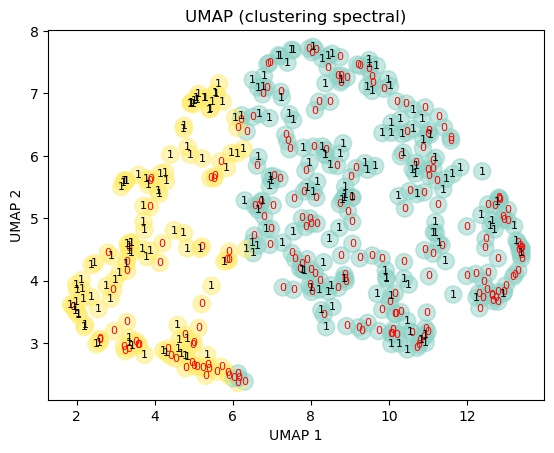

In [17]:

# sc et om concaténés
dataframe=pd.concat([frequences_sc,frequences_om],axis=1)
dataframe=dataframe.T

tissus=[]
for i in range (224): 
    tissus.append(0)
for j in range (224):   
    tissus.append(1)
tissus=np.array(tissus)
colors = ['yellow', 'lightgreen']
colors2 = ['red','black']

## CLUSTERING SPECTRAL
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')         
labels = model.fit_predict(dataframe)


reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umap = reducer.fit_transform(dataframe)

plt.figure()
plt.scatter(frequences_umap[:, 0], frequences_umap[:, 1],c=labels, cmap='Set3',linewidths=1.2, s=150,alpha=0.5)   
for i, label in enumerate(tissus):
    plt.text(frequences_umap[i, 0], frequences_umap[i, 1], str(label),fontsize=8, va='center', ha='center',color=colors2[label])
plt.title("UMAP (clustering spectral)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

### **FIT D'UNE FONCTION POLYNOME** ###

In [18]:
frequences_scT = frequences_sc.T
frequences_omT = frequences_om.T

In [19]:
dg=4
def f(X,a,b,c,d,e):
    fx=a*X**3+b*X**2+c*X+d+e*X**4
    return fx

def sse(p):
        a,b,c,d,e=p
        d=np.sum(((f(X,a,b,c,d,e))- y)**2)
        return d


a,b,c,d,e=5.68186909e-09,  -1.5691237e-06, 1.73964552e-08, 1.77509390e-02, 1.77509390e-02

parameters_sc=[]
for i in range(1,225):
    h=scdf[f"patient {i}"].dropna() 
    X=np.linspace(min(h),max(h),49)
    y=frequences_scT.loc[f"patient {i}"]
    

    p0=-8.88612724e-8,  1.12854316e-2,  7.04081842e-08,  9.33158278e-10,-1.98918766e-7

    p_opt=fmin(sse,p0)

    a,b,c,d,e=p_opt
    fx=f(X,a,b,c,d,e)
    
    parameters_sc.append(p_opt)
    
    plt.figure()
    plt.plot(X,fx,label="f(x) fitted")
    plt.hist(scdf[f"patient {i}"].dropna(), bins=50, density=True, alpha=0.5, label='données brutes',linewidth=2) 
    plt.legend()
    plt.title(f"[TISSU ADIPEUX SOUS CUTANÉ]\nhistogramme données brutes + polynome\n du patient {i}")
    plt.xlabel("taille des adipocytes (µm)")
    plt.ylabel("frequence")
    # plt.show()
    plt.close()

Optimization terminated successfully.
         Current function value: 0.000540
         Iterations: 107
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 0.000238
         Iterations: 129
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 0.000462
         Iterations: 123
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 0.001377
         Iterations: 118
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: 0.000715
         Iterations: 118
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: 0.000584
         Iterations: 113
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: 0.000428
         Iterations: 126
         Function evaluations: 227
Optimization termina

### **FIT DE 2 GAUSSIENNES** ###
fit pour fréquences sous cutanés : pour avoir viscéral, faut remplacer *frequences_scT* par *frequences_omT*

Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 108
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 117
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 106
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 120
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 127
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 100
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 123
         Function evaluations: 215
Optimization termina

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


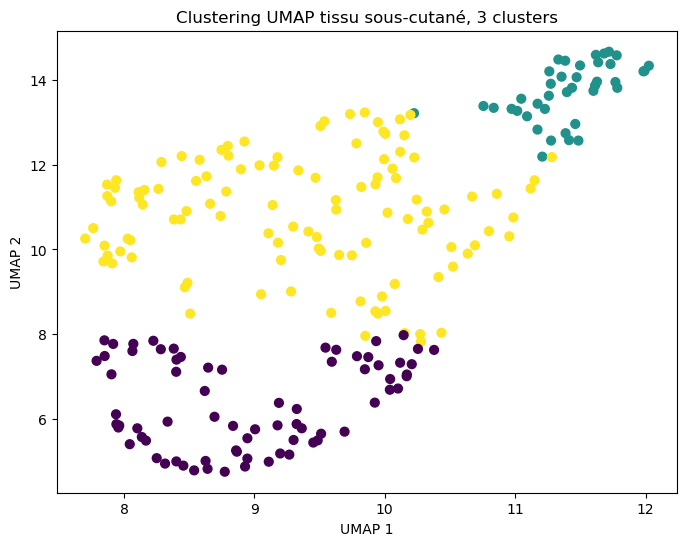

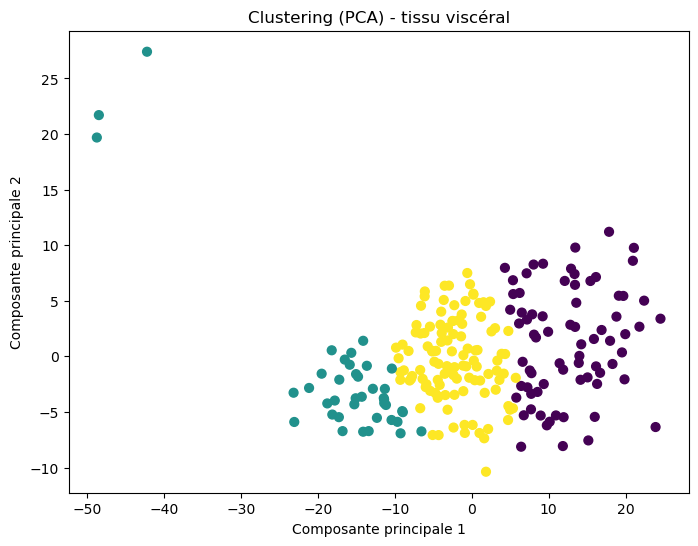

In [20]:
def sse(p): 
    s1,m1,s2,m2=p
    d = np.sum((fx(b[1:], s1, m1, s2, m2) - frequences_scT.loc[f"patient {patient}"][:len(b[1:])]) ** 2)
    return d

def fx (X,s1,m1,s2,m2):
    pic1=1/(2*np.sqrt(2*np.pi)*s1)*np.exp(-((X-m1)**2/(2*s1**2)))
    pic2=1/(2*np.sqrt(2*np.pi)*s2)*np.exp(-((X-m2)**2/(2*s2**2)))
    return pic1+pic2

s1=19
m1=40
s2=20
m2=80

matrix = pd.DataFrame(frequences_scT)

for patient in range(1,len(scdf.columns)+1) :  
    h=scdf[f"patient {patient}"].dropna()
    data,b=np.histogram(h,bins=binning,density=True)
    
    p0=20,48.2,17,80
    p_opt=fmin(sse,p0)
    s1,m1,s2,m2=p_opt

    fx(b[1:],s1,m1,s2,m2)   
    gauss1=1/(2*np.sqrt(2*np.pi)*s1)*np.exp(-((b[1:]-m1)**2/(2*s1**2)))
    gauss2=1/(2*np.sqrt(2*np.pi)*s2)*np.exp(-((b[1:]-m2)**2/(2*s2**2)))
        
    pic1 = 1/(2*np.sqrt(2*np.pi)*s1)
    p_pic1 = m1  
    pic2 = 1/(2*np.sqrt(2*np.pi)*s2)
    p_pic2 = m2
    
    distrib=gauss1+gauss2
    
    # nadir_idx = np.argmin(distrib[np.argmax(gauss1):np.argmax(gauss2)]) + np.argmax(gauss1)
    # nadir = b[1:][nadir_idx]
    
    result = {
        "position pic 1": p_pic1,
        "hauteur du pic 1": pic1,
        "position pic 2": p_pic2,
        "écart type 2": s2,
        "hauteur du pic 2": pic2,
        # "nadir" : nadir
    }

    matrix.loc[f"patient {patient}",["position pic1", "hauteur pic 1","position pic2", "sd 2", "hauteur pic 2"]] = p_pic1,pic1,p_pic2,s2,pic2
     
    plt.figure()
    plt.hist(h, bins=binning, alpha=0.5, density=True,label='données brutes',linewidth=2) 
    plt.plot(b[:-1], frequences_scT.loc[f"patient {patient}"], label="courbe de fréquences lissées")
    plt.plot(b[:-1],fx (b[1:],s1,m1,s2,m2),label="2 gaussiennes")
    plt.plot(b[:-1],gauss1,label="gauss1")
    plt.plot(b[:-1],gauss2,label="gauss2")
    plt.plot(p_pic1,pic1,'.',label="position pic 1")
    plt.plot(p_pic2,pic2,'.',label="position pic 2")
    plt.legend()
    plt.title(f"TA sous cutané\nfit 2 gaussiennes : patient {patient}")
    # plt.show()
    plt.close()


# CLUSTERING SPECTRAL

clustering_matrix = np.array(matrix)        
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')         
labels_sc = model.fit_predict(clustering_matrix)


#%% UMAP

reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
frequences_umap = reducer.fit_transform(clustering_matrix)

plt.figure(figsize=(8,6))
plt.scatter(frequences_umap[:, 0], frequences_umap[:, 1], c=labels_sc, cmap='viridis', s=40)
plt.title(f"Clustering UMAP tissu sous-cutané, 3 clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

#%% PCA 
pca = PCA(n_components=2)
frequences_pca = pca.fit_transform(clustering_matrix) 


# plot PCA avec couleurs du clustering spectral
plt.figure(figsize=(8,6))
plt.scatter(frequences_pca[:, 0], frequences_pca[:, 1], c=labels_sc, cmap='viridis', s=40)              
plt.title(f"Clustering (PCA) - tissu viscéral")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()


### **CLUSTERING SUR FREQUENCES + DONNEES 2 GAUSSIENNES + QTTE LIPIDES + PROPORTION DE GROSSES CELLULES** ###

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


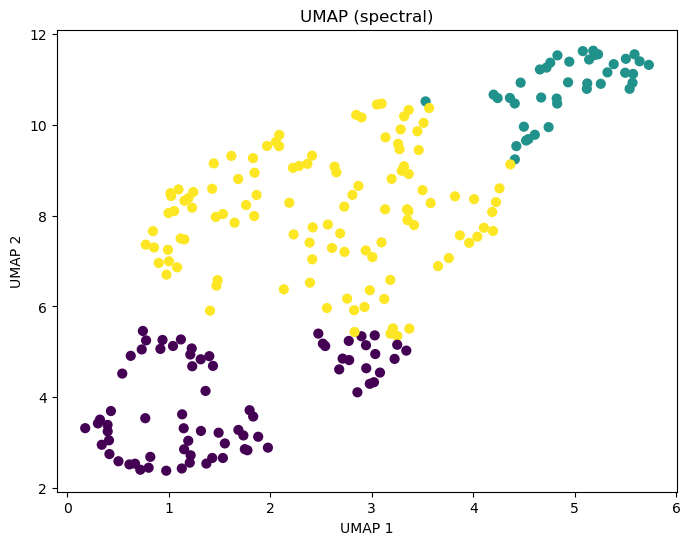

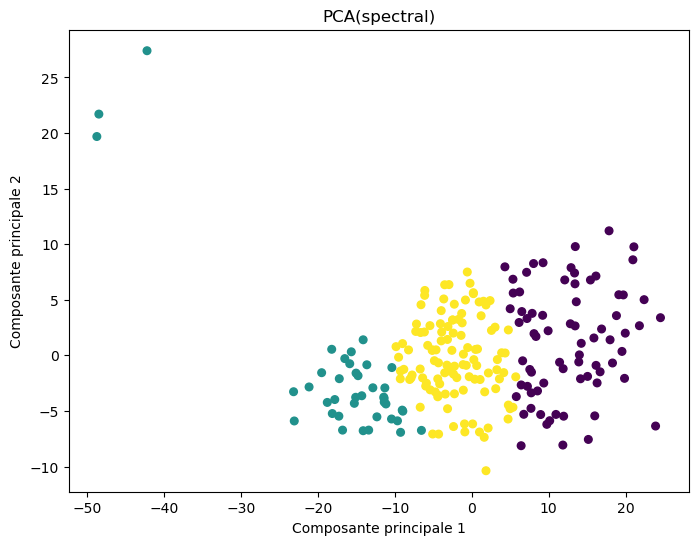

In [21]:
proportion_big_sc = pd.DataFrame(proportion_big_sc,index=[f"patient {i}" for i in range(1,225)])
sc_ltot = pd.DataFrame(sc_ltot,index=[f"patient {i}" for i in range(1,225)])
matrice_principale = pd.concat([matrix,proportion_big_sc,sc_ltot], axis=1) 

### SI ON VEUT VOIR AVEC LA MATRICE PRINCIPALE SANS : 
    ## SANS LES FREQUENCES ###
# matrice_principale = pd.concat([matrix,proportion_big_sc,qtte_lpd_sc.T], axis=1) #concat verticale : ajout de colonnes 

     ## SANS MATRIX ###
# matrice_principale = pd.concat([frequences_scT,proportion_big_sc,qtte_lpd_sc.T], axis=1) #concat verticale : ajout de colonnes 
    
     ## QUE FREQ ###
# matrice_principale = pd.concat([frequences_scT], axis=1) #concat verticale : ajout de colonnes 

# CLUSTERING SPECTRAL
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')      
labels = model.fit_predict(matrice_principale.values)

# UMAP 
reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
frequences_umap = reducer.fit_transform(matrice_principale)
plt.figure(figsize=(8,6))
plt.scatter(frequences_umap[:, 0], frequences_umap[:, 1], c=labels, cmap='viridis', s=40)
plt.title(f"UMAP (spectral)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

# PCA 
pca = PCA(n_components=2)
frequences_pca = pca.fit_transform(matrice_principale.values) 
plt.figure(figsize=(8,6))
plt.scatter(frequences_pca[:, 0], frequences_pca[:, 1], c=labels, cmap='viridis', s=30)              
plt.title("PCA(spectral)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()


### **ETAT DU RESEAU, PLUSIEURS CLUSTERINGS** ###

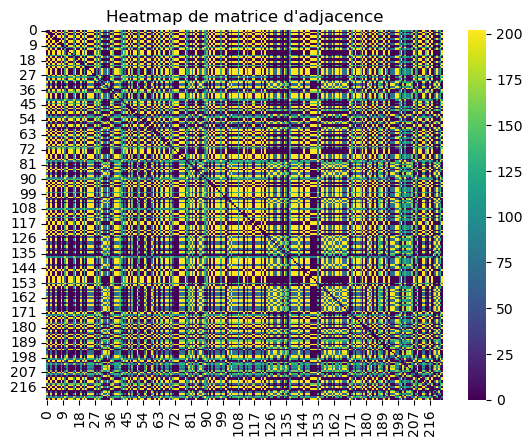

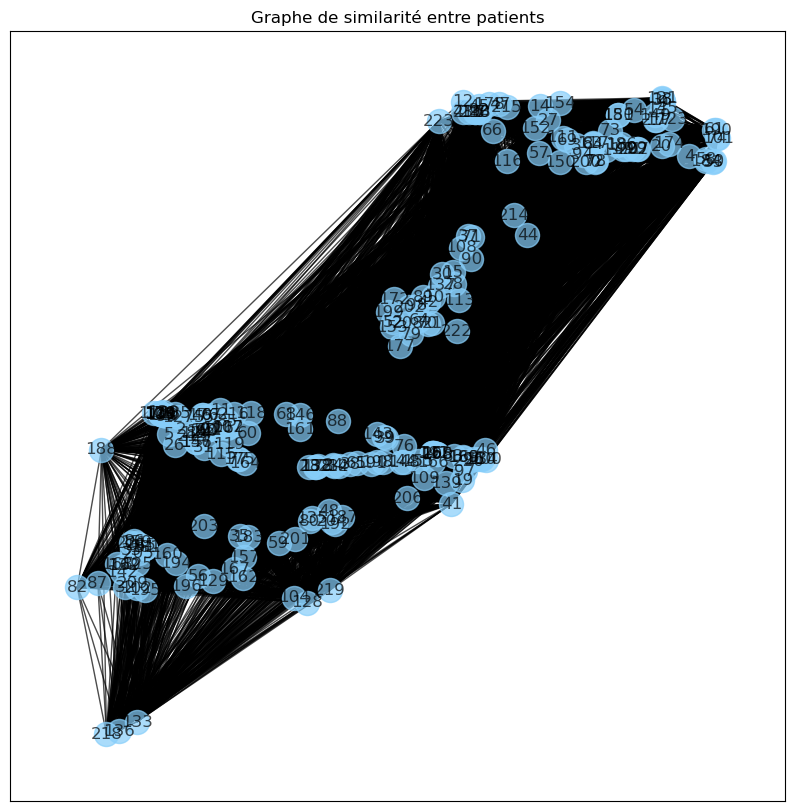

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


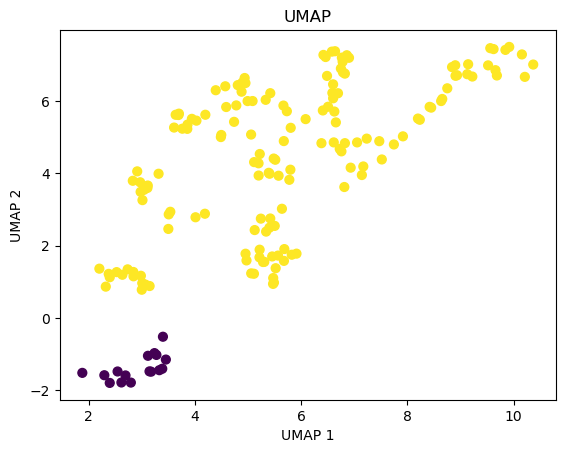

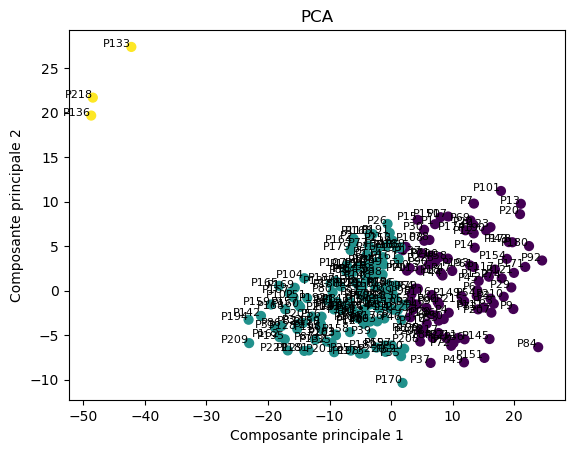

In [22]:
labels_list=[]
nb_seed=100

#%% CLUSTERING SPECTRAL 
modelCS = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')          
labels_cs = modelCS.fit_predict(matrice_principale.values)*nb_seed
labels_list.append(labels_cs)

#%% HDBSCAN
clusterer_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = clusterer_hdb.fit_predict(matrice_principale)
labels_hdb = np.where(labels_hdb == -1, np.nan, labels_hdb)*nb_seed  # remplacer -1 par nan
labels_list.append(labels_hdb)

#%% KMEANS
for i in range(nb_seed):
    kmeans = KMeans(n_clusters=3, random_state=i)
    labels_km=kmeans.fit_predict(matrice_principale.values)
    labels_list.append(labels_km)

#%% GAUSSIAN MIXTURE
for i in range(nb_seed):
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=i)
    gmm.fit(matrice_principale.values)
    labels_gm = gmm.predict(matrice_principale.values)
    labels_list.append(labels_gm)

#%% MATRICE D'ADJACENCE

adj_matrix = np.zeros((len(matrice_principale),len(matrice_principale)))
for l in range (len(labels_list)):
    for i in range (len(matrice_principale)):        
        for j in range (len(matrice_principale)):
            if labels_list[l][i]==labels_list[l][j]:
                adj_matrix[i,j] += 1
np.fill_diagonal(adj_matrix, 0)  
          
# VISUALISATION MATRICE D'ADJACENCE : heatmap 

sns.heatmap(adj_matrix, cmap="viridis")  # ou 'coolwarm' 'magma'
plt.title("Heatmap de matrice d'adjacence")
plt.show()

G = nx.from_numpy_array(adj_matrix) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, node_size=300, node_color="lightskyblue",alpha=0.7)
plt.title("Graphe de similarité entre patients")
plt.show()

#%% UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umap = reducer.fit_transform(matrice_principale.values)
plt.figure()
plt.scatter(frequences_umap[:, 0], frequences_umap[:, 1], c=labels_hdb, cmap='viridis', s=40)
plt.title("UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

# APC
pca = PCA(n_components=2)
frequences_pca = pca.fit_transform(matrice_principale.values)
labels = [f"P{i}" for i in range(len(matrice_principale))] #chaque colonne = le n° de patient 
plt.figure()
plt.scatter(frequences_pca[:, 0], frequences_pca[:, 1], c=labels_km, cmap='viridis', s=40)   
for i, label in enumerate(labels):
    plt.text(frequences_pca[i, 0], frequences_pca[i, 1], str(label), fontsize=8, ha='right')
plt.title(f"PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()


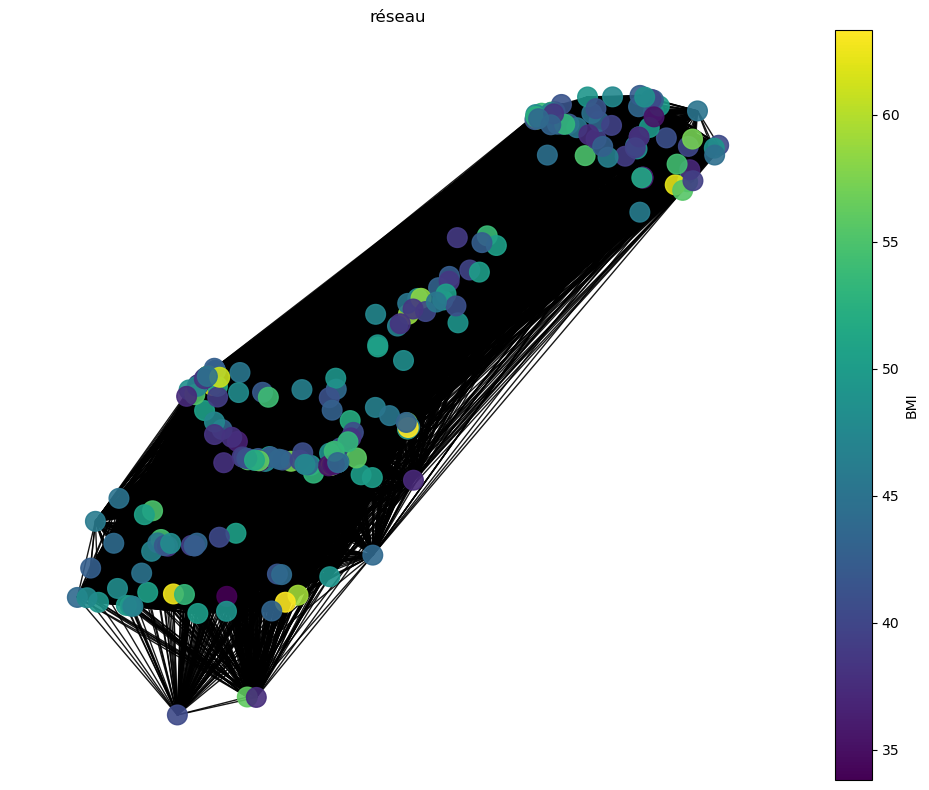

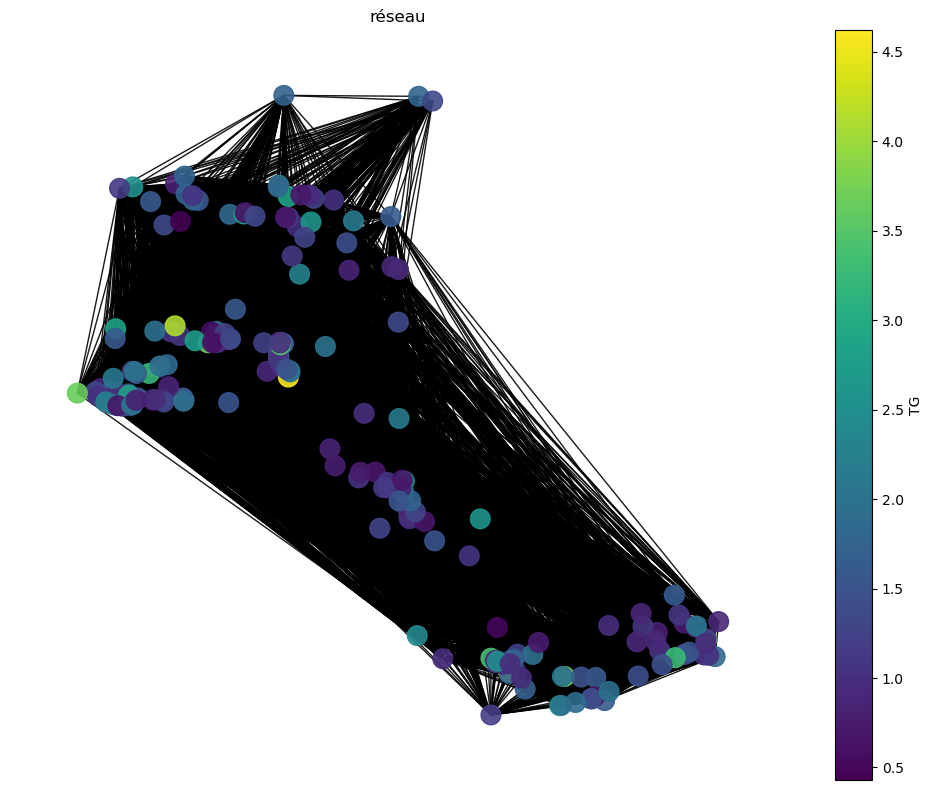

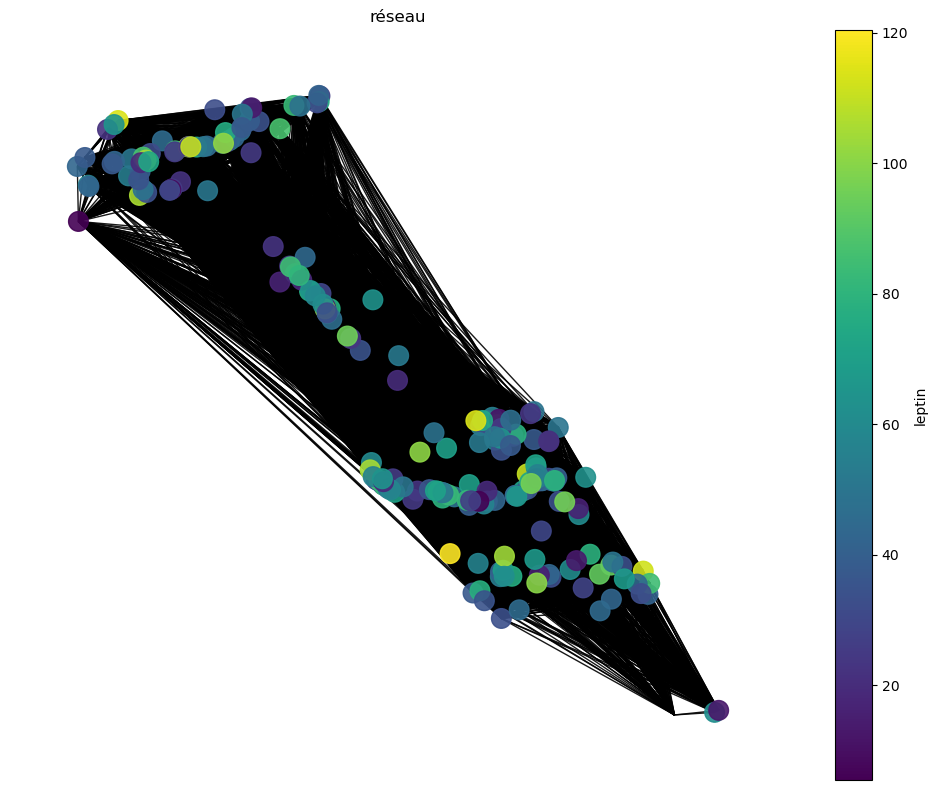

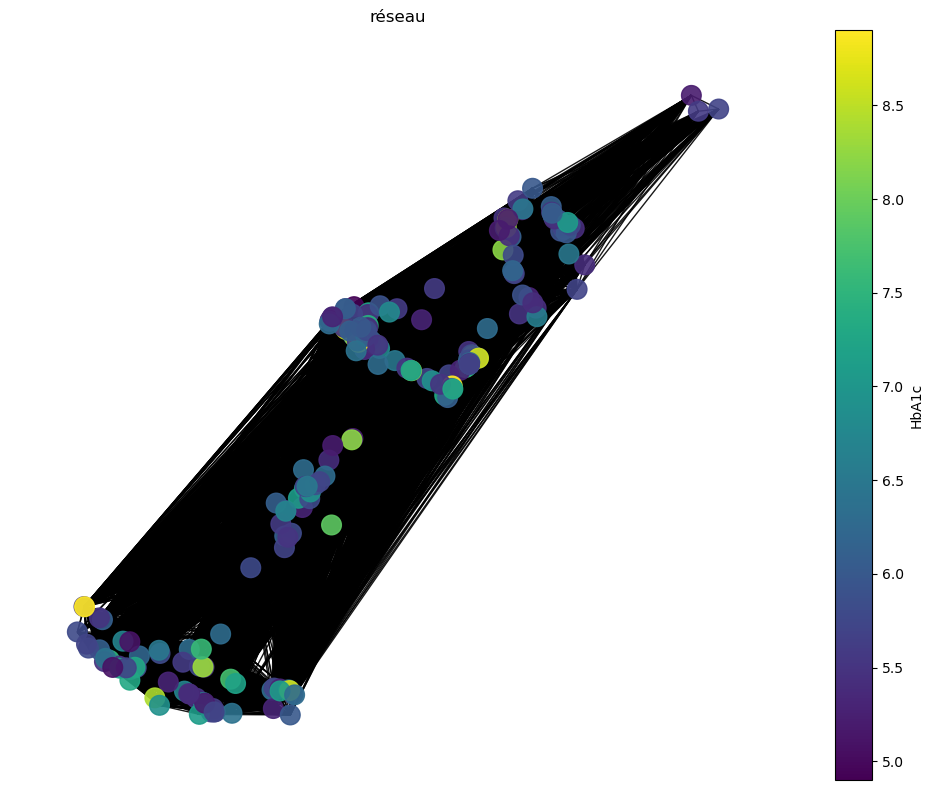

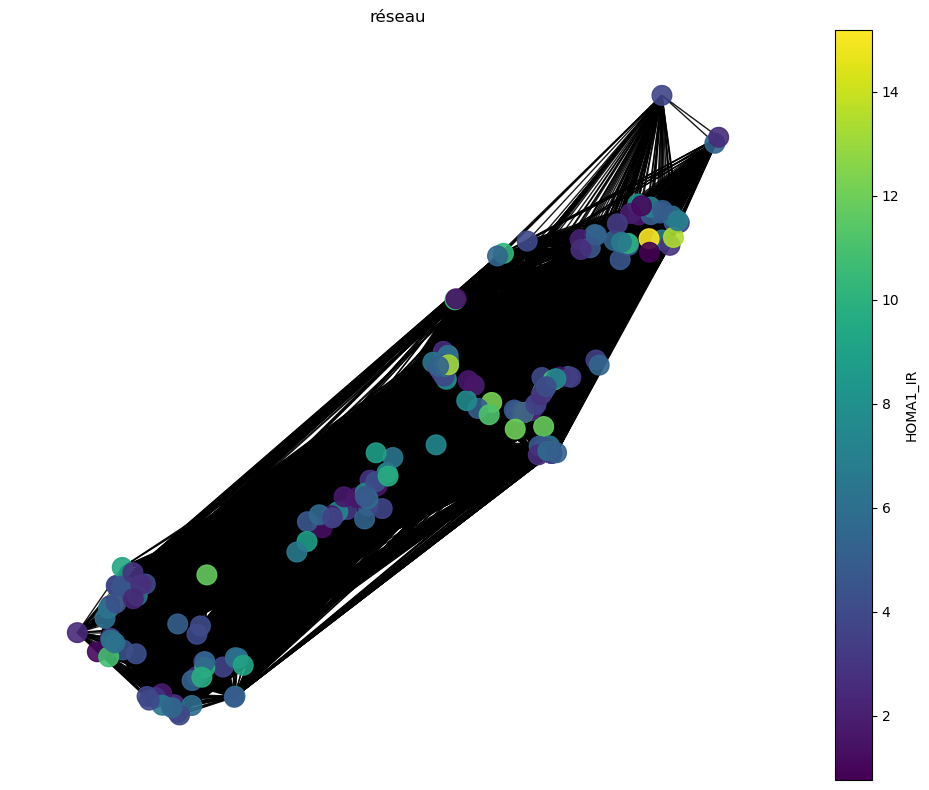

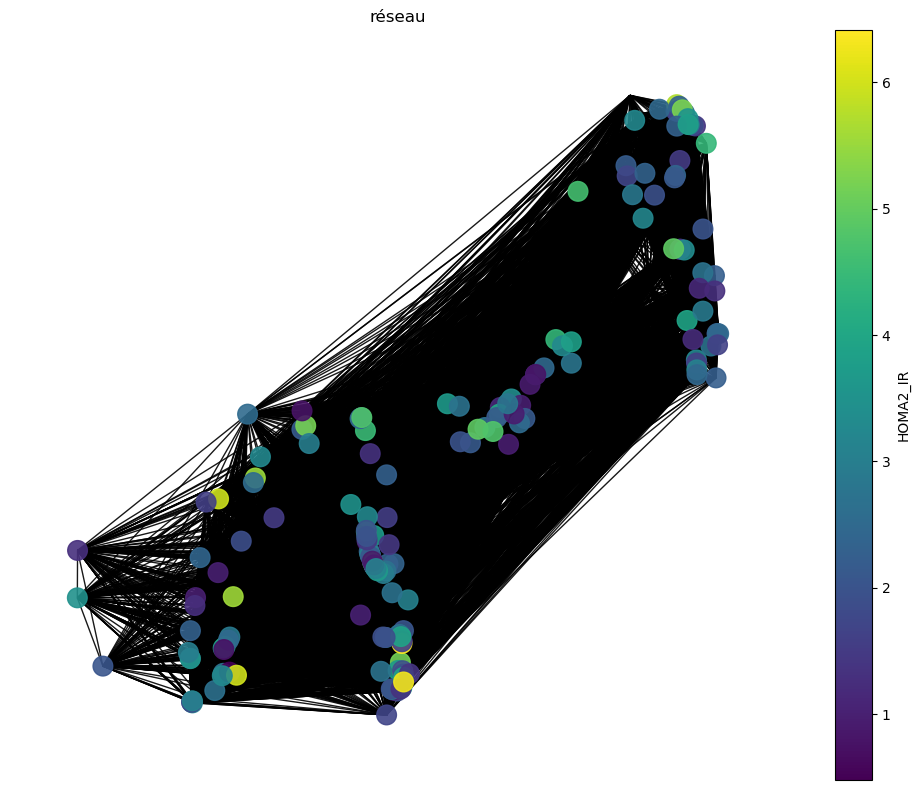

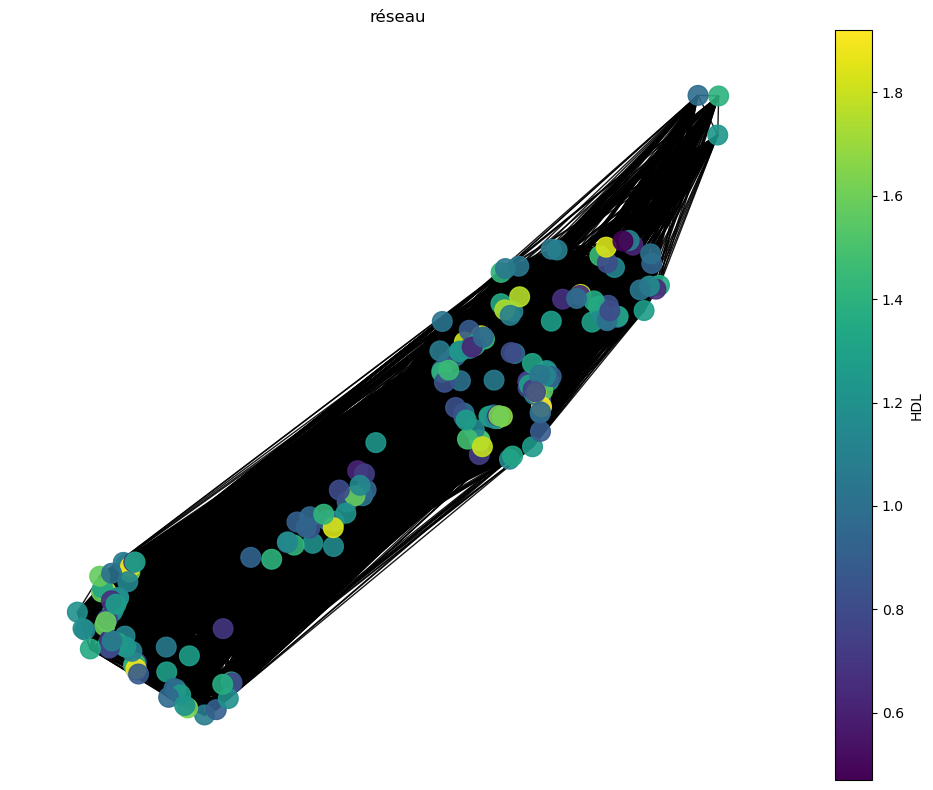

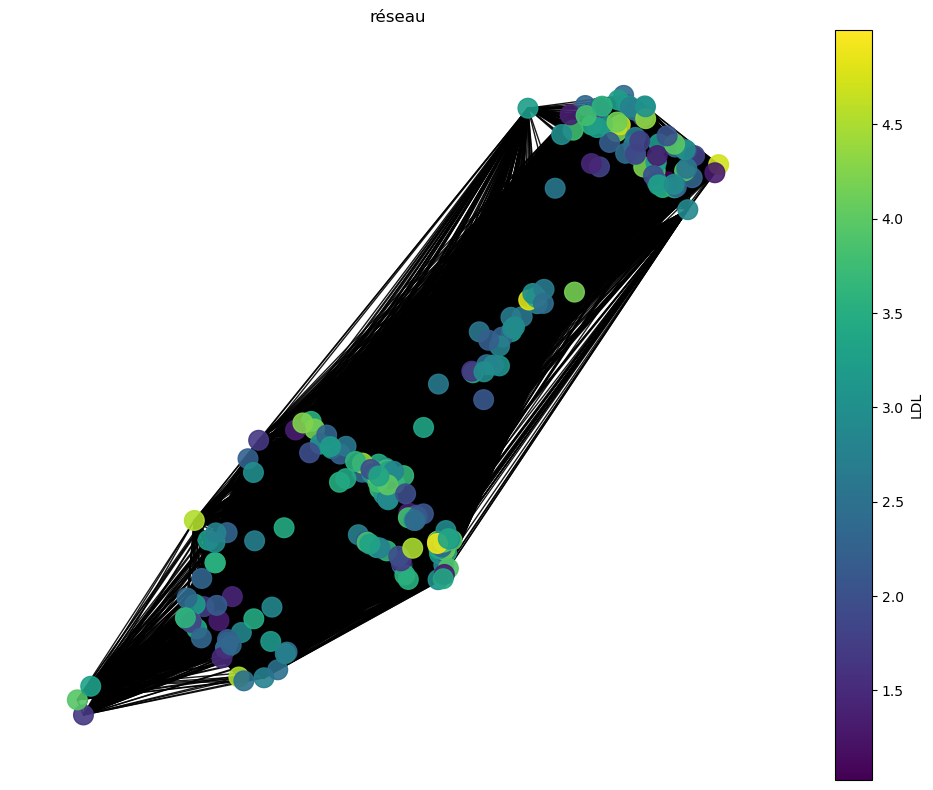

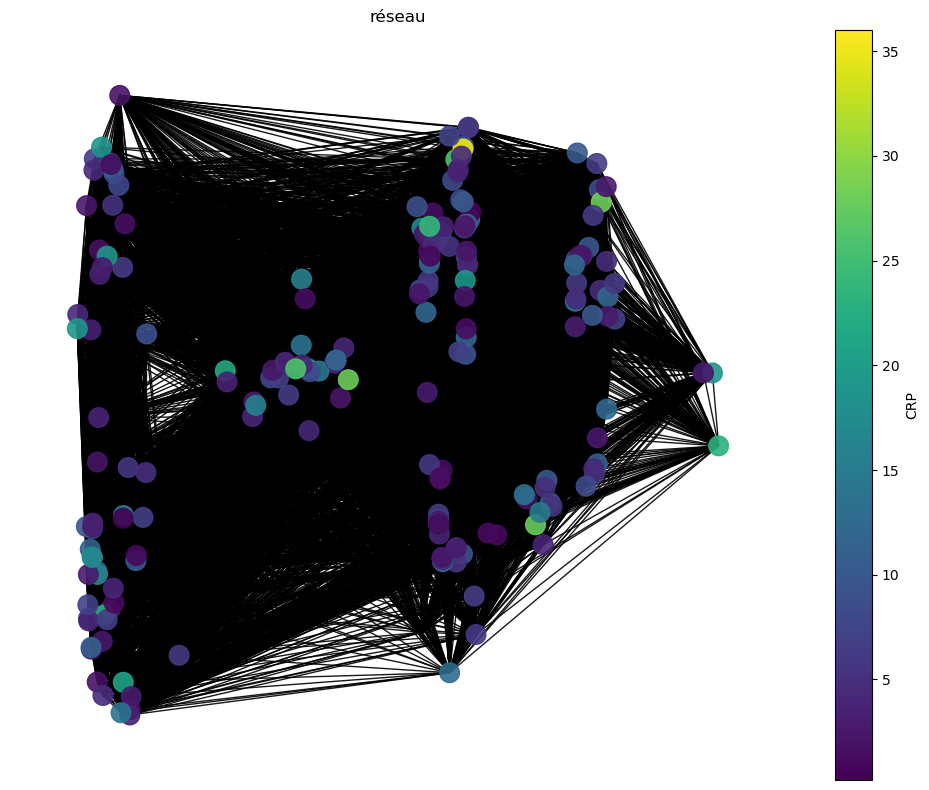

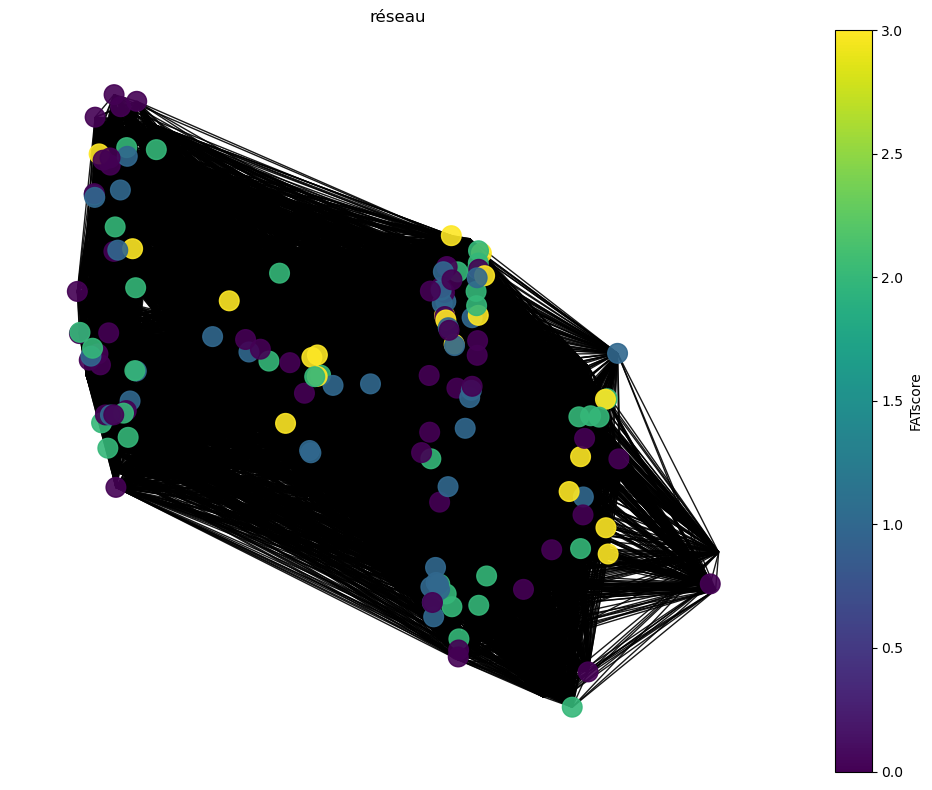

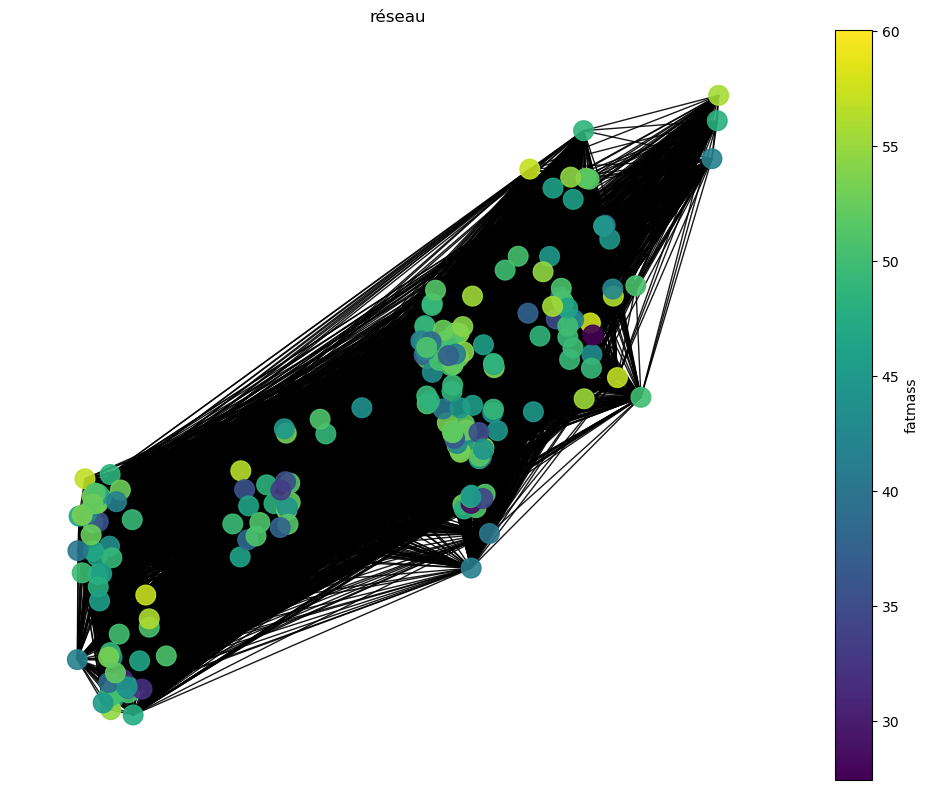

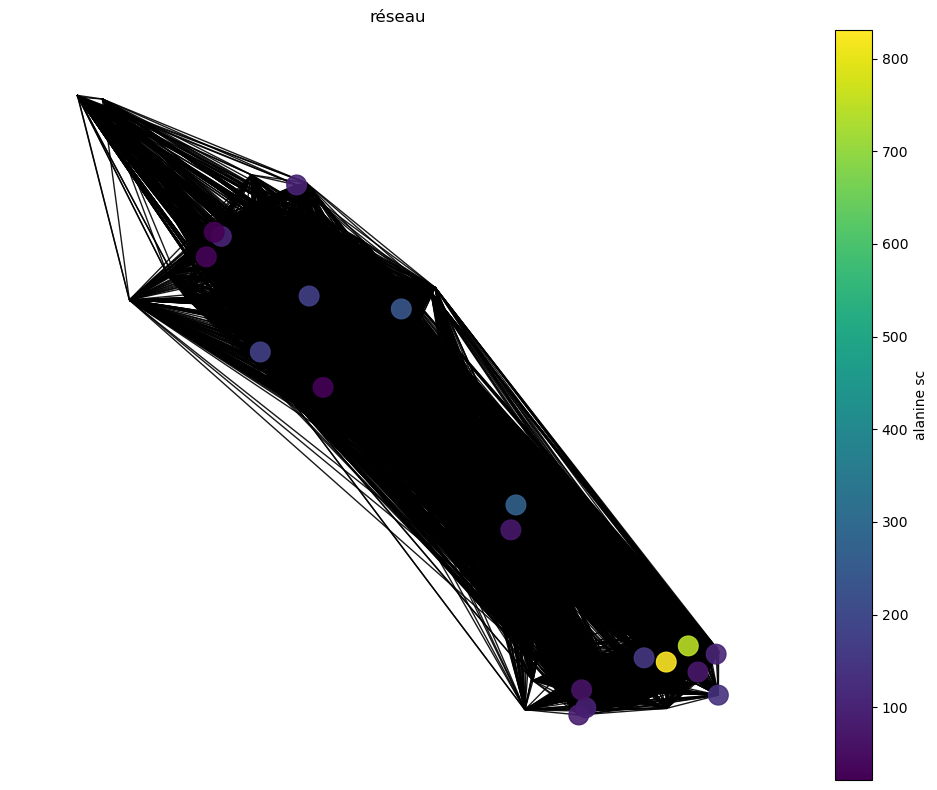

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not N° patient
patient 1                   NaN
patient 2                   NaN
patient 3                   NaN
patient 4                   NaN
patient 5                   NaN
                     ...       
patient 220    16.2651393821626
patient 221                 NaN
patient 222                 NaN
patient 223                 NaN
patient 224    17.3525620872798
Name: AA-Aspartic acid WAT SCAT, Length: 224, dtype: object

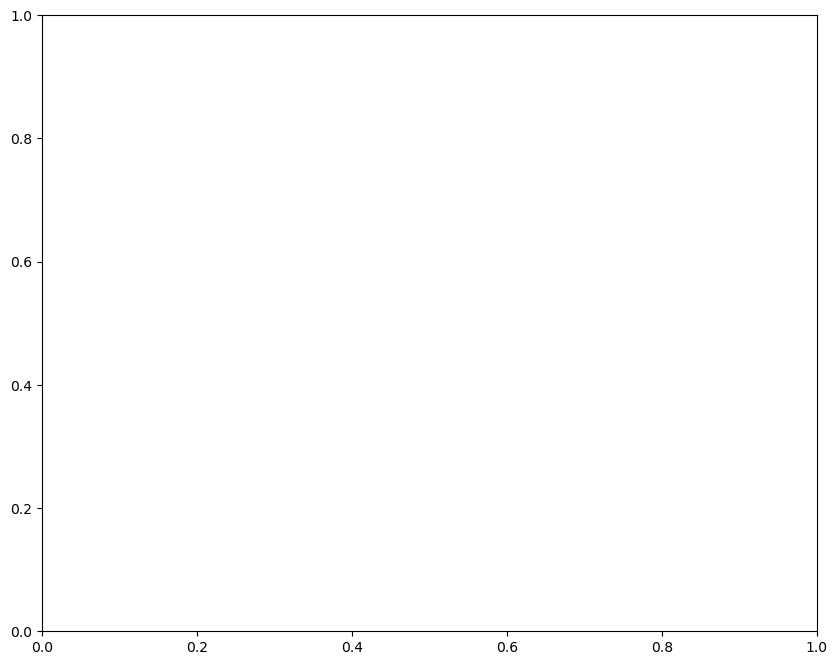

In [23]:
for choix in variables_m.keys() :        

    labels_v = variables_m[choix]   

    G = nx.from_numpy_array(adj_matrix) 
    fig, ax = plt.subplots(figsize=(10, 8))  # On récupère un axe explicite
    
    node_values = variables_m[f"{choix}"]   
    nodes = nx.draw_networkx(G, node_size=200, node_color=node_values, cmap="viridis", alpha=0.9,with_labels=False)
    
    # Création d'un scatter plot pour la colorbar
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=node_values.min(), vmax=node_values.max()))
    sm.set_array([])  # Nécessaire pour la compatibilité matplotlib
    
    fig.colorbar(sm, ax=ax, label=choix)
    ax.set_title("réseau")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
